In [1]:
!pip install opencv-python
!pip install opencv-contrib-python
!pip install opencv-python-headless
!pip install opencv-contrib-python-headless
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 66.1 MB/s eta 0:00:00


In [2]:
#import google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
from skimage import io  #to read double values from tif file images
from matplotlib import pyplot as plt
import PIL
import rasterio as rio  #to read full map
import pandas as pd
#from skimage.feature import peak_local_max
from skimage.measure import label
from sklearn.metrics import confusion_matrix
from PIL import Image
import seaborn as sb

In [4]:
root = '/content/drive/MyDrive/DCC - Diego Villatoro Gerónimo/'
folder = root+"Datos Tesis Referencia/Datasets/Zone3/"
#Folder should contain the tif files of the images to analyze
#Each tif file contain the data of the image: B, G, R, Re, NIR, ..., Target
#Data in folder was normalized according to histogram of the hightest representative value, that is raw data over 0.314 and clip 0 to 1

#<font color= Blue>Utils</font>

##<font color= Green>testing</font>

In [5]:
#find valley in a histogram with n values greater before and n values greater after
def find_valleys(hist, n):
  valleys = []
  for i in range(n, len(hist)-n):
    flag = 0
    i_tmp = i-n
    while(i_tmp<i):
      #if hist[i_tmp]>hist[i_tmp+1]:
      if hist[i_tmp]>hist[i_tmp+1] or (hist[i_tmp]>0.95*hist[i_tmp+1] and hist[i_tmp]>hist[i]):
        i_tmp+=1
      else:
        flag=1
        break
    if flag==0:
      i_tmp = i+n
      while(i_tmp>i):
        #if hist[i_tmp-1]<hist[i_tmp]:
        if hist[i_tmp-1]<hist[i_tmp] or (hist[i_tmp]>0.95*hist[i_tmp-1] and hist[i_tmp]>hist[i]):
          i_tmp-=1
        else:
          flag=1
          break
    else:
      continue
    if flag==0:
      #print(i)
      valleys.append(i)
  return valleys

In [6]:
#find peaks in a histogram with n values smaller before and n values smaller after
def find_peaks(hist, n):
  peaks = []
  for i in range(n, len(hist)-n):
    flag = 0
    i_tmp = i-n
    while(i_tmp<i):
      #previous value is smaller than next or the next value is slighly small but even small than expected peak
      if hist[i_tmp]<hist[i_tmp+1] or (hist[i_tmp]<1.05*hist[i_tmp+1] and hist[i_tmp]<hist[i]):
        i_tmp+=1
      else:
        flag=1
        break
    if flag==0:
      i_tmp = i+n
      while(i_tmp>i):
        if hist[i_tmp-1]>hist[i_tmp] or (hist[i_tmp]<1.05*hist[i_tmp-1] and hist[i_tmp]<hist[i]):
          i_tmp-=1
        else:
          flag=1
          break
    else:
      continue
    if flag==0:
      #print(i)
      peaks.append(i)

In [7]:
def get_total_hist_VI(VI_NAME, len_histo, min_histo, max_histo, pData=0.999, shadow_process=False, ranges=(0, 1), bounded=False, dischard_max_value_histogram=False, verbose=True):
  maxi = -np.inf
  mini = np.inf
  _hist = np.zeros((len_histo, 1))

  file_names = os.listdir(folder)
  file_names = [file_name for file_name in file_names if file_name[-3:]=='tif']

  for file_name in file_names:
      B, G, R, Re, NIR, target = read_channels(folder, file_name[:-4])
      if shadow_process:
        shadow_map = get_shadow_map(B, G, R, NIR, bin=False) #shadows are the 1's
        Im = cv2.merge((B, G, R))
        HSV = cv2.cvtColor(Im,cv2.COLOR_BGR2HSV)
        H, S, V = cv2.split(HSV)
        newI = cv2.cvtColor(cv2.merge((H, S, np.clip(V*(1+2*(1-shadow_map)), V.min(), V.max()) )), cv2.COLOR_HSV2RGB) #130
        newR, newG, newB = cv2.split(newI)
        Veg_Ind = VI((newB, newG, newR, Re, NIR), VI_NAME, ranges, bounded)
      else:
        Veg_Ind = VI((B, G, R, Re, NIR), VI_NAME, ranges, bounded)

      _hist += cv2.calcHist([Veg_Ind], [0], None, [len_histo], [min_histo, max_histo])
      if Veg_Ind.max()>maxi:
        maxi = Veg_Ind.max()
      if Veg_Ind.min()<mini:
        mini = Veg_Ind.min()

  #ESTIMATE MAX AND MIN VALUES FOR VI'S WITHOUT DEFINED BOUNDARIES
  totalNpixels = sum(_hist) #len(images)*len(R)*len(R[0])
  _hist_copy = _hist
  if dischard_max_value_histogram:
    largest = _hist.argmax()
    totalNpixels-=_hist[largest]
    _hist[largest] = 0
  x = np.linspace(min_histo, max_histo, len_histo)
  for j in range(len(_hist)):
    if sum(_hist[j:])/(totalNpixels) < pData:
      break
  for i in range(len(_hist)):
    if sum(_hist[:i])/(totalNpixels) > pData:
      break
  miniRecommended = x[j-1]
  maxiRecommended = x[i]
  if verbose:
    print("Min: %.4f, Max: %.5f" %(mini, maxi))
    print("Min limit recommended %4.6f in index %d" %(x[j-1], j-1))
    print("Max limit recommended %4.6f in index %d" %(x[i], i))
  return (mini, maxi), _hist_copy, (miniRecommended, maxiRecommended)

##<font color= Green>Evaluations</font>

In [8]:
#read B, G, R, Re, NIR channels and target from database
def read_channels(folder, imNumber):
  with rio.open(folder+imNumber+'.tif') as img :
    img_full = img.read()
  #X : Nc, H, W
  X = img_full[[0,1,2,3,4], :,:]

  B = img_full[0, :,:]
  G = img_full[1, :,:]
  R = img_full[2, :,:]
  Re = img_full[3, :,:]
  NIR = img_full[4, :,:]
  target = img_full[7, :,:]

  return B, G, R, Re, NIR, target

###Shadows

In [9]:
def F_highlight(x, a, y, b):
  return 1/(1+np.exp(-a*(1-x**(1/y)-b)))

def maxim(R, G, B):
  M = np.maximum(np.maximum(R, G), B)
  return M

def minim(a, t):
  M = np.where(a<t, a, t)
  return M

#Recive channels R, G, B, and NIR to compute the shadow map, if bin is enable return binarized shadow map, else return it in grayscale
#The values are from 0 to 1
def get_shadow_map(B, G, R, NIR, bin=False):
  #It is important to define F, mini and maxi functions
  a = 14#14 #for more sensitivity decrease value
  y = 2.2#2.2 #for more sensitivity decrease value
  b = 0.5#0.5 #for more sensitivity decrease value
  c = 10# 10

  I = (R + G + B)/3

  #Normalize values of I and NIR before compute funtion F to get values from 0 to 1
  # Visible shadow candidate map
  d_VIS = F_highlight(I/I.max(), a, y, b)
  #NIR shadow candidate map
  d_NIR = F_highlight(NIR/NIR.max(), a, y, b)
  D = d_VIS*d_NIR

  T_R = R/(NIR+0.000000000001)#add small small number to avoid division by 0
  T_G = G/(NIR+0.000000000001)
  T_B = B/(NIR+0.000000000001)
  T = minim( maxim(T_R, T_G, T_B), c)/c #return values from 0 to 1

  U = (1-D)*(1-T)

  if bin:
    # Applying Otsu's method setting the flag value into cv.THRESH_OTSU.
    # Optimal threshold value is determined automatically.
    otsu_threshold, U_bin = cv2.threshold((255*U).astype('uint8'), 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Dischard border pixels that does not contain image information
    #because inverse threshold is applied, when image has borders outside, these become 1's
    out_img_indices = np.where(np.logical_and(np.logical_and(R==0, G==0), B==0))
    U_bin[out_img_indices] = 0
    #ret,U_bin = cv2.threshold(U,otsu_threshold/255,1,cv2.THRESH_BINARY_INV)
    return (U_bin/255).astype('uint8')
  else:
    return U

###VI

In [10]:
#bands are between 0 and 1, the returned VI is also between 0 and 1
#ranges determine the bounds when bounded is true,
# also ranges[0] can move the 0 values or indefined (background of orthomosaic) to other position by initialize the output array of the VI
def VI(bands, vi_name, ranges=(0, 1), bounded = True):
  B = bands[0]
  G = bands[1]
  R = bands[2]
  Re = bands[3]
  NIR = bands[4]
  V_I = np.zeros_like(R)
  ############################################################################################
  #RANGES TO BOUNDED
  #RVI -----> (0, 1)
  #VIN -----> (0, 15)
  #NDVI ----> (-0.5, 1.0)
  #PVI -----> (-0.1 - 0.8)
  #PVI2 ----> (-0.1 - 0.4)
  #SAVI ----> (-0.3 - 0.8)
  #TSAVI1 --> (-5, 5)
  #TSAVI2 --> (-0.4-0.5)
  #NDGI ----> (-0.9 - 1)
  #RI ------> (-1.0 - 0.9)
  #RI_NDVI -> (-1 - 1.45)
  #RI_SAVI -> (-1.24 - 0.8)
  #ARVI ----> (-0.2 - 0.95)
  #NDCI ----> (-0.8 - 0.9)
  #MSAVI ---> (-0.2 - 0.8)
  #NLI -----> (-1 - 0.9)
  #RDVI ----> (-0.3, 0.7)
  #ExG -----> (-0.7, 0.9)
  #NDWI ----> (-1, 1)
  #GNDVI ---> (-0.7 - 1)
  #OSAVI ---> (-0.3 - 0.7)
  #MSR -----> (0 - 2.8)
  #SIPI ----> (0 - 3.1)
  #ExR -----> (-0.4 - 0.4)
  #MCARI ---> (-0.1-0.9)
  #NDRE ----> (-0.6 - 0.9)
  #TVI -----> (-14 - 39)
  #ARI -----> (-10, 86)
  #EVI -----> (0, 1.25)
  #CIVE ----> (18.4 - 19.1)
  #NRI -----> (0.0-0.8)
  #NGI -----> (0.0-0.92)
  #NBI -----> (0.0-0.85)
  #CCCI ----> (0, 1.7)
  #CCCI2 ---> (-0.375, 1.02)
  #EVI2 ----> (-0.2 - 0.8)
  #LCVI1 ---> (0 - 1)
  #LCVI2 ---> (0 - 1)
  #RCVI1 ---> (0 - 5.5)
  #RCVI2 ---> (0 - 1.7)
  #ILR1 ----> (-1.12, 1.84)
  #ILR2 ----> (-1.16-1.66)

  if vi_name == 'RVI':#rango abierto (0-INF) rango particular (0 - 2.7) rango acotado(0, 1)
    V_I = np.divide(R, NIR, out=np.zeros_like(R)+ranges[0], where=NIR!=0)
  elif vi_name == 'VIN':#rango abierto (0-INF) rango particular (0 - 32), rango acotado (0,15)
    V_I = np.divide(NIR, R, out=np.zeros_like(R)+ranges[0], where=R!=0)
  elif vi_name == 'NDVI': #rango (-1-1), rango particular (-0.5 - 1.0)
    V_I = np.divide(NIR-R, NIR+R, out=np.zeros_like(R)+ranges[0], where=(NIR+R)!=0)
  elif vi_name == 'PVI1': #rango (-0.385-0.923)   rango particular (-0.1 - 0.8)
    #V_I = (a*NIR-R-b)/np.sqrt(a**2+1) with a=2.4 and b=0.01
    V_I = np.add(0.923*NIR, -0.385*R, out=np.zeros_like(R)+ranges[0], where=((NIR+R)!=0))
  elif vi_name == 'PVI2': #rango (-0.676-0.737) rango particula (-0.1 - 0.4)
    #V_I = (a*Re-R-b)/np.sqrt(a**2+1) with a=1.091 and b=5.49
    V_I = np.add(0.737*Re, -0.676*R, out=np.zeros_like(R)+ranges[0], where=((Re+R)!=0))
  elif vi_name == 'SAVI': #rango (-1-1) rango particular (-0.3 - 0.8)
    V_I = np.divide(1.5*(NIR-R), NIR+R+0.5, out=np.zeros_like(R)+ranges[0], where=(NIR+R)!=0)
  elif vi_name == 'TSAVI1':#rango abierto (-INF-INF) rango acotado(-5, 5)
    a = 1.3
    b = 0.06
    V_I = np.divide(a*(NIR-a*R-b), a*NIR+R-a*b, out=np.zeros_like(R)+ranges[0], where=np.logical_and((NIR+R)!=0, (a*NIR+R-a*b)!=0))
  elif vi_name == 'TSAVI2':#rango abierto (-INF-INF)  rango particular (-0.71 - 0.7) rango acotado (-0.4-0.5)
    a = 1.3
    b = 0.06
    V_I = np.divide(a*(NIR-a*R-b), a*NIR+R-a*b+0.08*(1+a**2), out=np.zeros_like(R)+ranges[0], where=(NIR+R)!=0)
  elif vi_name == 'NDGI': #rango (-1-1) rango particular (-0.9 - 1)
    V_I = np.divide(G-R, G+R, out=np.zeros_like(R)+ranges[0], where=(G+R)!=0)
  elif vi_name == 'RI':#rango (-1-1) rango particular (-1.0 - 0.9)
    V_I = np.divide(R-G, R+G, out=np.zeros_like(R)+ranges[0], where=(R+G)!=0)
  elif vi_name == 'RI_NDVI':  #rango (-1.45-1.45) rango particular (-1 - 1.45)
    k = 0.45
    NDVI = np.divide(NIR-R, NIR+R, out=np.zeros_like(R), where=(NIR+R)!=0)
    RI = np.divide(R-G, R+G, out=np.zeros_like(R), where=(R+G)!=0)
    V_I = np.add(NDVI, -k*RI, out=np.zeros_like(R)+ranges[0], where=((NDVI)!=0))
  elif vi_name == 'RI_SAVI': #rango (-1.26-1.26) rango particular (-1.24 - 0.8)
    k = 0.26
    SAVI = np.divide(1.5*(NIR-R), NIR+R+0.5, out=np.zeros_like(R), where=(NIR+R)!=0)
    RI = np.divide(R-G, R+G, out=np.zeros_like(R), where=(R+G)!=0)
    V_I = np.add(SAVI, -k*RI, out=np.zeros_like(R)+ranges[0], where=((SAVI)!=0))
  elif vi_name == 'ARVI': #rango (-INF, INF) rango particular (-0.6-11) rango acotado (0-1)
    y=0.5
    RB = R-y*(B-R)
    V_I = np.divide(NIR-RB, NIR+RB, out=np.zeros_like(R)+ranges[0], where=np.logical_and((NIR+R)!=0, (NIR+RB)!=0)) #out is shiftted to initialize the 0's with the corresponding min values

  elif vi_name == 'NDCI':#rango (-1-1) rango particular (-0.8 - 0.9)
    V_I = np.divide(Re-R, Re+R, out=np.zeros_like(R)+ranges[0], where=(Re+R)!=0)
  elif vi_name == 'MSAVI':#rango (-1-1 o 1.5)? rango particular (-0.2 - 0.8)
    V_I = np.divide(2*NIR+1-np.sqrt((2*NIR+1)**2-8*(NIR-R)), 2, out=np.zeros_like(R)+ranges[0], where=(NIR+R)!=0)
  elif vi_name == 'NLI':#rango (-1-1) rango particular (-1 - 0.9)
    V_I = np.divide(NIR**2-R, NIR**2+R, out=np.zeros_like(R)+ranges[0], where=(NIR+R)!=0)
  elif vi_name == 'RDVI':#rango (-1-1) rango particular (-0.3, 0.7)
    V_I = np.divide(NIR-R, np.sqrt(NIR+R), out=np.zeros_like(R)+ranges[0], where=(np.sqrt(NIR+R))!=0)
  elif vi_name == 'ExG': #rango (-2, 2) rango particular (-0.7, 0.9)
    V_I = np.add(2*G, -R-B, out=np.zeros_like(R)+ranges[0], where=((R+G+B)!=0))
  elif vi_name == 'NDWI':
    V_I = np.divide(G-NIR, G+NIR, out=np.zeros_like(R)+ranges[0], where=(G+NIR)!=0)
  elif vi_name == 'GNDVI': #rango (-1-1) rango particular (-0.7 - 1)
    V_I = np.divide(NIR-G, NIR+G, out=np.zeros_like(R)+ranges[0], where=(NIR+G)!=0)
  elif vi_name == 'OSAVI': #rango (-1, 1) rango particular (-0.3 - 0.7)
    V_I = np.divide(NIR-R, NIR+R+0.16, out=np.zeros_like(R)+ranges[0], where=(NIR+R)!=0)

  elif vi_name == 'MSR': #rango (-1, INF) rango particular (-0.4 - 4.7) rango acotado (0 - 2.8)
    V_I = np.divide(NIR-R, R+np.sqrt(NIR*R), out=np.zeros_like(R)+ranges[0], where=R+np.sqrt(NIR*R)!=0)
  elif vi_name == 'SIPI': #rango (-INF, INF)
    V_I = np.divide(NIR-B, NIR-R, out=np.zeros_like(R)+ranges[0], where=(NIR-R)!=0)
  elif vi_name == 'ExR': #rango (-1-1.3) rango particular (-0.4 - 0.4)
    V_I = np.add(1.3*R, -G, out=np.zeros_like(R)+ranges[0], where=((R+G)!=0))
  elif vi_name == 'MCARI': #rango(-INF-INF) rango particular (-0.2 - 2.7) rango acotado (-0.1-0.9)
    V_I = np.divide((Re-R-0.2*(Re-G))*Re, R, out=np.zeros_like(R)+ranges[0], where=(R)!=0)
  elif vi_name == 'NDRE':  #rango (-1-1) rango particular (-0.6 - 0.9)
    V_I = np.divide(NIR-Re, NIR+Re, out=np.zeros_like(R)+ranges[0], where=(NIR+Re)!=0)
  elif vi_name == 'TVI': #rango (-100, 100) rango particular (-14 - 39)
    V_I = np.add(60*NIR+40*G, -100*R, out=np.zeros_like(R)+ranges[0], where=((NIR+R+G)!=0))
  elif vi_name == 'ARI': #rango (-INF, INF) rango particular (-121 - 359) rango acotado (-10, 86)
    V_I = np.divide(Re-G, G*Re, out=np.zeros_like(R)+ranges[0], where=(G*Re)!=0)
  elif vi_name == 'EVI': #rango (-INF, INF) rango particular (-372637 - 1416), rango acotado (0, 1.25)
    L, c1, c2, g = 1, 6, 7.5, 2.5
    V_I = np.divide(g*(NIR-R), NIR+c1*R-c2*B+L, out=np.zeros_like(R)+ranges[0], where=(NIR+R+B)!=0)
  elif vi_name == 'CIVE': #rango(18 - 20) rango particular(18.4 - 19.1)
    V_I = np.add(0.441*R, -0.811*G+0.385*B+18.78745, out=np.zeros_like(R)+ranges[0], where=((R+G+B)!=0))
  elif vi_name == 'NRI': #rango(0-1), rango particular (0.0-0.8)
    V_I = np.divide(R, R+G+B, out=np.zeros_like(R)+ranges[0], where=(R+G+B)!=0)
  elif vi_name == 'NGI': #rango(0-1), rango particular (0.0-0.92)
    V_I = np.divide(G, R+G+B, out=np.zeros_like(R)+ranges[0], where=(R+G+B)!=0)
  elif vi_name == 'NBI': #rango(0-1), rango particular (0.0-0.85)
    V_I = np.divide(B, R+G+B, out=np.zeros_like(R)+ranges[0], where=(R+G+B)!=0)
  elif vi_name == 'CCCI': #rango (-INF, INF) rango particular (-73005 - 263474) rango de datos (0, 1.7)
    NDRE = np.divide(NIR-Re, NIR+Re, out=np.zeros_like(R), where=(NIR+Re)!=0)
    NDVI = np.divide(NIR-R, NIR+R, out=np.zeros_like(R), where=(NIR+R)!=0)
    V_I = np.divide(NDRE, NDVI, out=np.zeros_like(R)+ranges[0], where=(NDVI)!=0)
  elif vi_name == 'CCCI2': #rango (-INF, INF) rango particular (-60594 - 218683) rango de datos (-0.375, 1.02)
    NDRE = np.divide(NIR-Re, NIR+Re, out=np.zeros_like(R), where=(NIR+Re)!=0)
    NDVI = np.divide(NIR-R, NIR+R, out=np.zeros_like(R), where=(NIR+R)!=0)
    V_I = np.divide(NDRE, NDVI, out=np.zeros_like(R)+ranges[0], where=(NDVI)!=0)
    V_I = 0.83*V_I-0.375
  elif vi_name == 'EVI2': #rango (-0.74 - 1.25), rango particular (-0.2 - 0.8)
    g, c1, L = 2.5, 2.4, 1
    V_I = np.divide(g*(NIR-R), NIR+c1*R+L, out=np.zeros_like(R)+ranges[0], where=(NIR+R)!=0)

  elif vi_name == 'LCVI1':
    ARVI = VI(bands, 'ARVI')
    RVI = VI(bands, 'RVI')
    TSAVI2 = VI(bands, 'TSAVI2')
    NDVI = VI(bands, 'NDVI')
    NLI = VI(bands, 'NLI')
    CCCI = VI(bands, 'CCCI')
    MSR = VI(bands, 'MSR')
    SIPI = VI(bands, 'SIPI')
    NDCI = VI(bands, 'NDCI')
    GNDVI = VI(bands, 'GNDVI')
    V_I = (0.249*ARVI+0.238*RVI+0.183*TSAVI2+0.107*NDVI+0.071*NLI+0.058*CCCI+0.052*MSR+0.029*SIPI+0.009*NDCI+0.004*GNDVI)  #Best according to uniformity in histograms but weighted
  elif vi_name == 'LCVI2':
    ARVI = VI(bands, 'ARVI')
    RVI = VI(bands, 'RVI')
    TSAVI2 = VI(bands, 'TSAVI2')
    NLI = VI(bands, 'NLI')
    MSR = VI(bands, 'MSR')
    V_I = 0.43*ARVI+0.148*RVI+0.227*TSAVI2+0.069*NLI+0.126*MSR #Best weighted according to combined histograms metrics
  elif vi_name == 'RCVI1':
    ARVI = VI(bands, 'ARVI')
    NLI = VI(bands, 'NLI')
    CCCI = VI(bands, 'CCCI')
    V_I = np.divide(ARVI*NLI, CCCI, out=np.zeros_like(ARVI)+ranges[0], where=CCCI!=0)
  elif vi_name == 'RCVI2':
    ARVI = VI(bands, 'ARVI', norm)
    TSAVI2 = VI(bands, 'TSAVI2', norm)
    RVI = VI(bands, 'RVI', norm)
    CCCI = VI(bands, 'CCCI', norm)
    V_I = np.divide(ARVI*TSAVI2*RVI, CCCI, out=np.zeros_like(ARVI)+ranges[0], where=CCCI!=0)
  elif vi_name == 'ILR1': #RANGO (-7.35 - 5.65) rango particular (-1.12, 1.84)
    V_I = np.add(2.14*B+0.24*G-7.35*R, 0.8*Re+2.15*NIR+0.32, out=np.zeros_like(R)+ranges[0], where=((R+G+B)!=0))
  elif vi_name == 'ILR2': #RANGO (-4.21 - 2.88) rango particular (-1.16-1.66)
    V_I = np.add(2.65*NIR, -4.21*R+0.23, out=np.zeros_like(R)+ranges[0], where=((R+G+B)!=0))
  if bounded: #bound the range of the VI and scale to be between 0 and 1
    V_I = np.clip(V_I, ranges[0], ranges[1]-0.001) #set little small to upper bound to avoid overflow in uin8
    V_I = (V_I-ranges[0])/(ranges[1]-ranges[0])

  return V_I.astype('float32')

###Segmentation

In [11]:
def filter_min_components(binIMG, minSize=100, it_dilate=3, it_erode=1):
  # Apply the Component analysis function
  (totalLabels, label_ids, values, centroid) = cv2.connectedComponentsWithStats(binIMG, 4, cv2.CV_32S)

  # Initialize a new image to store all the output components
  output_temp = np.zeros(binIMG.shape, dtype="uint8")

  # Loop through each component
  for i in range(1, totalLabels):
      area = values[i, cv2.CC_STAT_AREA]
      if (area > minSize):
          # Labels stores all the IDs of the components on the each pixel
          # It has the same dimension as the threshold
          # So we'll check the component
          # then convert it to 255 value to mark it white
          componentMask = (label_ids == i).astype("uint8")

          # Creating the Final output mask
          output_temp = cv2.bitwise_or(output_temp, componentMask)
  #dilate 3 times + erode 1 to improve the shape
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
  output = cv2.dilate(output_temp, kernel, iterations=it_dilate)
  output = cv2.erode(output, kernel, iterations=it_erode)
  return output

In [12]:
#fid the nearest element in the array to the given value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

###Score

$Acc = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = \frac{(TP+TN)}{(TP+FP+FN+TN)}$

$Acc_{class0} = \text{Specificity} = \frac{TN}{TN+FP}$

$Acc_{class1} = \text{Recall} = \frac{TP}{TP+FN}$

$IoU = \frac{\text{Intersection (Number of correct predictions)}}{\text{Union (Predictions + True values - Intersection})}$

$IoU_{class0} = \frac{TN}{TN+FN+FP}$
$IoU_{class1} = \frac{TP}{TP+FN+FP}$

$Precision = \frac{TP}{TP+FP}$

$F1 score = DICE = \frac{2TP}{2TP+FP+FN}$

In [13]:
from sklearn.metrics import confusion_matrix

def metrics(confusion: np.ndarray) -> tuple:
    """
    Return metrics evaluating a categorical classification task.
    Args:
        confusion: the confusion matrix between ground truth and predictions
    Returns:
        metrics and values of confusion
    """
    # Confusion matrix
    tn, fp, fn, tp = confusion.ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    specificity = tn/(tn+fp) if (tn+fp)!=0 else 1
    recall = tp/(tp+fn) if (tp+fn)!=0 else 1
    precision = tp/(tp+fp) if (tp+fp)!=0 else 1
    iou = tp/(tp+fn+fp) if (tp+fn+fp)!=0 else 1
    dice = 2*tp/(2*tp+fp+fn) if (2*tp+fp+fn)!=0 else 1

    return accuracy*100, specificity*100, recall*100, precision*100, iou*100, dice*100, tn, fp, fn, tp

###Unet

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from collections import OrderedDict
import torchvision

#import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
import rasterio as rio

In [15]:
def accuracy(y_hat, y):
  # y_hat : [batch size, n classes]
  # y : [batch size]
  #compute the number of correct predictions
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
    # y_hat : [batch size]
  cmp = y_hat.type(y.dtype)==y
  #cmp = np.logical_and((y_hat.type(y.dtype)==y).cpu() , (y!=torch.zeros_like(y)).cpu() )
  #a = float(cmp.type(y.dtype).sum())
  #b = float((y!=torch.zeros_like(y)).type(y.dtype).sum())
  return float(cmp.type(y.dtype).sum())/ (len(y))

In [16]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ).to(device)

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        ).to(device)

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2).to(device)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1).to(device)

    def forward(self, x):
        return self.conv(x)

In [17]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits = logits.permute(0, 2, 3, 1)
        # X: batch_size, H, W, num_classes
        return logits


#<font color= Blue>Shadow map</font>

(-0.5, 223.5, 223.5, -0.5)

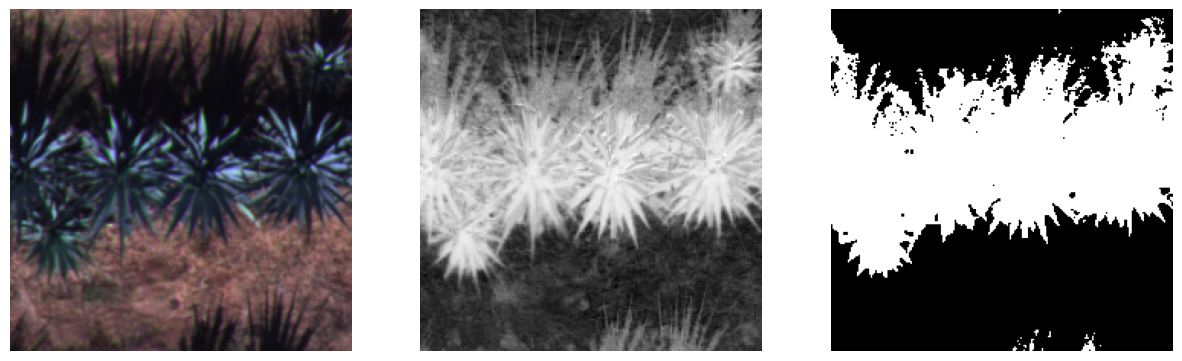

In [26]:
B, G, R, Re, NIR, t = read_channels(folder, '0853')
ARVI = VI((B, G, R, Re, NIR),'ARVI')
#otsu segmentation
ret,seg = cv2.threshold((255*ARVI).astype('uint8'),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

I = cv2.merge((R, G, B))
I = (255*I/I.max()).astype('uint8') #Scale to save image

Im = Image.fromarray(I) #convert to pil image
Im.save("shadows.png", "PNG") #save image

Im = Image.fromarray(seg) #convert to pil image
Im.save("seg_noise.png", "PNG") #save image

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(I, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(ARVI, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(seg, cmap='gray')
plt.axis('off')

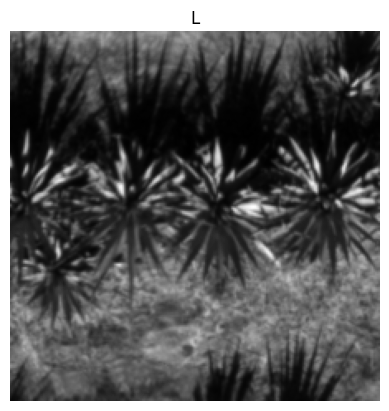

In [27]:
L = (R + G + B)/3

plt.imshow(L, cmap='gray')
plt.title('L')
plt.axis('off')
#plt.savefig('shadowL.png')
Im = Image.fromarray((255*L/L.max()).astype('uint8')) #convert to pil image
Im.save("L.png", "PNG") #save image

$f(x) = {1}/({1+e^{-a(1-x^{1/y}-b)}})$

In [28]:
def F_highlight(x, a, y, b):
  return 1/(1+np.exp(-a*(1-x**(1/y)-b)))

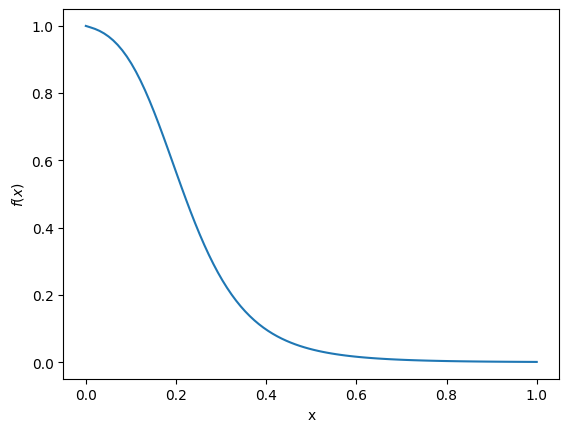

In [29]:
x = np.linspace(0,1,100)
z = F_highlight(x, 14, 2.2, 0.5)
plt.plot(x, z)
plt.ylabel('$f(x)$')
plt.xlabel('x')
plt.savefig('shadowF.png')

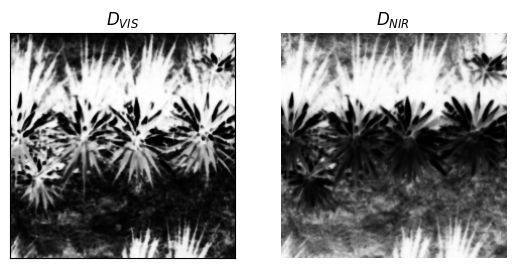

In [30]:
a = 14#14 #for more sensitivity decrease value
y = 2.2#2.2 #for more sensitivity decrease value
b = 0.5#0.5 #for more sensitivity decrease value

#Normalize values of I and NIR before compute funtion F to get values from 0 to 1
# Visible shadow candidate map
d_VIS = F_highlight(L/L.max(), a, y, b)
#NIR shadow candidate map
d_NIR = F_highlight(NIR/NIR.max(), a, y, b)

plt.subplot(1, 2, 1)
plt.imshow(d_VIS, cmap='gray')
plt.title("$D_{VIS}$")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.subplot(1, 2, 2)
plt.imshow(d_NIR, cmap='gray')
plt.title("$D_{NIR}$")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.axis('off')
#plt.savefig('shadowDs.png')
Im = Image.fromarray((255*d_VIS/d_VIS.max()).astype('uint8')) #convert to pil image
Im.save("Dvis.png", "PNG") #save image
Im = Image.fromarray((255*d_NIR/d_NIR.max()).astype('uint8')) #convert to pil image
Im.save("Dnir.png", "PNG") #save image

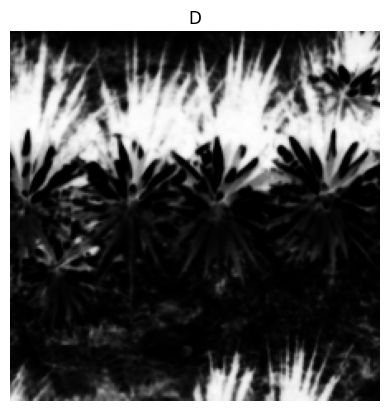

In [31]:
D = d_VIS*d_NIR
plt.imshow(D, cmap='gray')
plt.title('D')
plt.axis('off')
#plt.savefig('shadowD.png')
Im = Image.fromarray((255*D/D.max()).astype('uint8')) #convert to pil image
Im.save("D.png", "PNG") #save image

In [32]:
def maxim(R, G, B):
  M = np.maximum(np.maximum(R, G), B)
  return M

def minim(a, t):
  M = np.where(a<t, a, t)
  return M

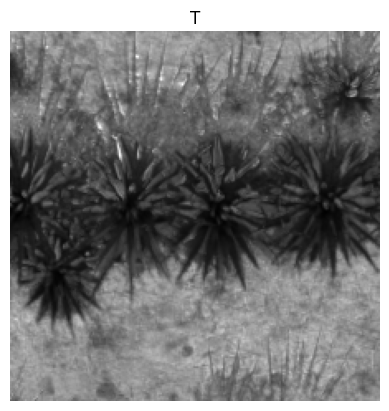

In [33]:
c = 10# 10
T_R = R/(NIR+0.000000000001)#add small small number to avoid division by 0
T_G = G/(NIR+0.000000000001)
T_B = B/(NIR+0.000000000001)
T = minim( maxim(T_R, T_G, T_B), c)/c #return values from 0 to 1

#cv2_imshow(255*T)
plt.imshow(T, cmap='gray')
plt.title('T')
plt.axis('off')
#plt.savefig('shadowT.png')
Im = Image.fromarray((255*T/T.max()).astype('uint8')) #convert to pil image
Im.save("T.png", "PNG") #save image

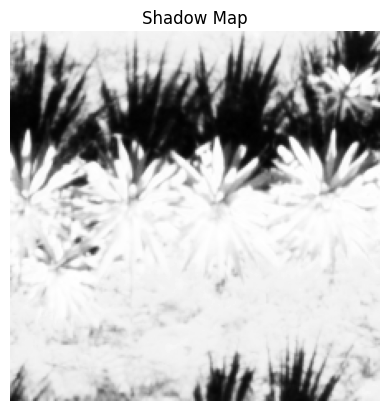

In [34]:
U = (1-D)*(1-T)
#cv2_imshow(255*U)
plt.imshow(U, cmap='gray')
plt.title("Shadow Map")
plt.axis('off')
#plt.savefig('shadowU.png')
Im = Image.fromarray((255*U/U.max()).astype('uint8')) #convert to pil image
Im.save("U.png", "PNG") #save image

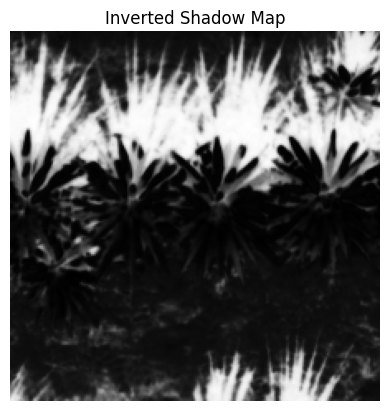

In [35]:
U_inv = 1-U
#cv2_imshow(255*U)
plt.imshow(U_inv, cmap='gray')
plt.title("Inverted Shadow Map")
plt.axis('off')
#plt.savefig('shadowUinv.png')
Im = Image.fromarray((255*U_inv/U_inv.max()).astype('uint8')) #convert to pil image
Im.save("Uinv.png", "PNG") #save image

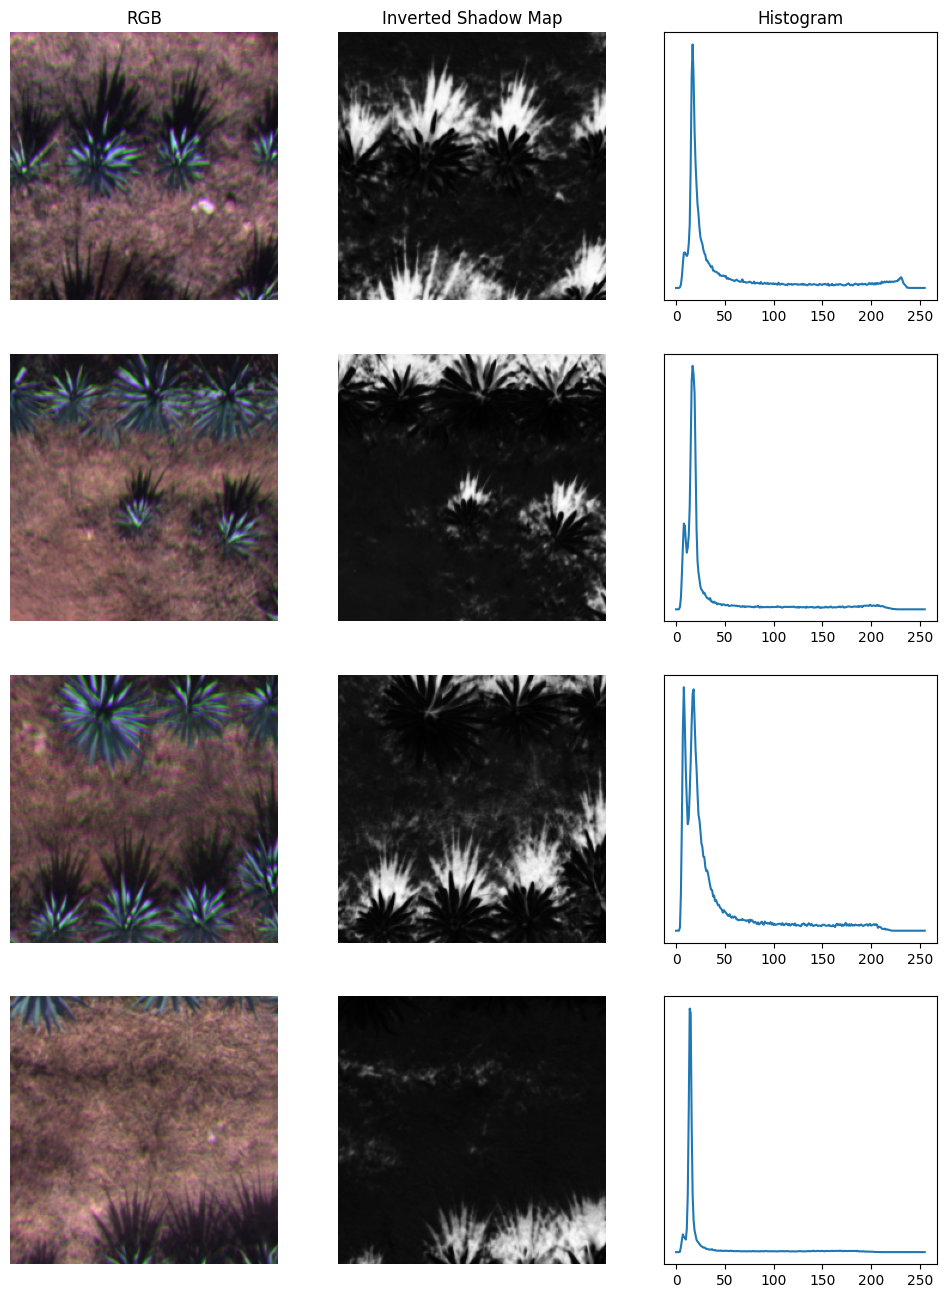

In [38]:
im = ['0911', '0704', '0624', '0412']
plt.figure(figsize=(12,16))
for i in range(len(im)):
  B, G, R, Re, NIR, target = read_channels(folder, im[i])
  U = get_shadow_map(B, G, R, NIR, bin=False)

  scale=255/max(B.max(), max(R.max(), G.max()))
  rgb = (scale*cv2.merge((R, G, B))).astype('uint8')

  plt.subplot(len(im), 3, 3*i+1)
  plt.imshow(rgb)
  if i==0:
    plt.title('RGB')
  plt.axis('off')

  plt.subplot(len(im), 3, 3*i+2)
  plt.imshow(1-U, cmap='gray')
  if i==0:
    plt.title('Inverted Shadow Map')
  plt.axis('off')

  tmp_hist = cv2.calcHist([(255*(1-U)).astype('uint8')], [0], None, [256], [0, 256])
  plt.subplot(len(im), 3, 3*i+3)
  plt.plot(tmp_hist)
  if i==0:
    plt.title('Histogram')
  plt.yticks([])
  #plt.axis('off')
plt.savefig('ShadowMapExamples.png')

#<font color= Blue>ARVI</font>

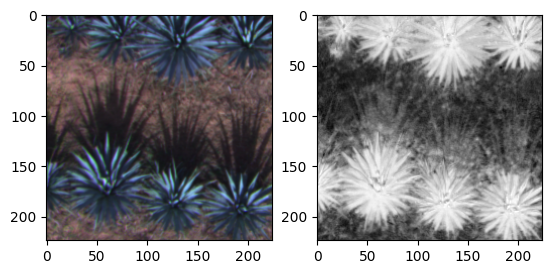

In [93]:
#B, G, R, Re, NIR, t = read_channels(folder, '0216')
#B, G, R, Re, NIR, t = read_channels(folder, '0853')
#B, G, R, Re, NIR, t = read_channels(folder, '0647')
B, G, R, Re, NIR, t = read_channels(folder, '0356')

##Img 1
scale = 255/(max(R.max(), max(G.max(), B.max())))
rgb = (scale*cv2.merge((R, G, B))).astype('uint8')
#Img 2
ARVI = VI((B, G, R, Re, NIR),'ARVI', ranges=(0, 0.94), bounded=True)
ARVI = ((255*ARVI)/ARVI.max()).astype('uint8')

plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.subplot(1, 2, 2)
plt.imshow(ARVI, cmap='gray')

Im = Image.fromarray(rgb) #convert to pil image
Im.save("RGB.png", "PNG") #save image
Im = Image.fromarray(ARVI) #convert to pil image
Im.save("ARVI.png", "PNG") #save image

In [94]:
#Find the images files with more valleys in histograms
file_names = os.listdir(folder)
file_names = [file_name for file_name in file_names if file_name[-3:]=='tif']
classes = ('background', 'agave')
data = []
maximos = 0
for  i, file_name in enumerate(file_names):
  #print('\r', "Image: ", i, end='')
  #imN = imNs[i]
  B, G, R, Re, NIR, target = read_channels(folder, file_name[:-4])
  U = get_shadow_map(B, G, R, NIR, bin=False)

  #Img 1
  scale=255/max(B.max(), max(R.max(), G.max()))
  rgb = (scale*cv2.merge((R, G, B))).astype('uint8')

  #Img 2
  ARVI = VI((B, G, R, Re, NIR),'ARVI', ranges=(0, 0.94), bounded=True)
  _hist = cv2.calcHist([(255*ARVI).astype('uint8')], [0], None, [256], [0, 256])

  if len(find_valleys(_hist, 5))>=3:
    print(file_name)

0088.tif
0092.tif


In [95]:
im = ['0846', '0184', '0216', '0853', '0823', '0518','0257']
plt.figure(figsize=(5*4,len(im)*4))
for i in range(len(im)):
  B, G, R, Re, NIR, target = read_channels(folder, im[i])
  U = get_shadow_map(B, G, R, NIR, bin=False)

  #Img 1
  scale=255/max(B.max(), max(R.max(), G.max()))
  rgb = (scale*cv2.merge((R, G, B))).astype('uint8')

  #Img 2
  ARVI = VI((B, G, R, Re, NIR),'ARVI', ranges=(0, 0.94))
  ARVI = ((255*ARVI)/ARVI.max()).astype('uint8')

  plt.subplot(len(im), 5, 5*i+1)
  plt.imshow(rgb)
  if i==0:
    plt.title('RGB')
  plt.axis('off')

  plt.subplot(len(im), 5, 5*i+2)
  plt.imshow(1-U, cmap='gray')
  if i==0:
    plt.title('Inverted Shadow Map')
  plt.axis('off')

  tmp_hist = cv2.calcHist([(255*(1-U)).astype('uint8')], [0], None, [256], [0, 256])
  plt.subplot(len(im), 5, 5*i+3)
  plt.plot(tmp_hist)
  if i==0:
    plt.title('Shadow Map Histogram')
  plt.yticks([])

  plt.subplot(len(im), 5, 5*i+4)
  plt.imshow(ARVI, cmap='gray')
  if i==0:
    plt.title('ARVI')
  plt.axis('off')

  tmp_hist = cv2.calcHist([ARVI], [0], None, [256], [0, 256])
  plt.subplot(len(im), 5, 5*i+5)
  plt.plot(tmp_hist)
  if i==0:
    plt.title('ARVI Histogram')
  plt.yticks([])

plt.savefig('ShadowMapExamples.png')

Output hidden; open in https://colab.research.google.com to view.

In [56]:
#Find a proper range of values of the VI
min_histo = -0.2 #the smallest found value of the VI in dataset
max_histo = 1.6 #the largest found value of the VI in dataset
len_histo = int(np.ceil(256*(max_histo-min_histo))) #define the number of bits of the histogram to setup a step of 1/256
VI_NAME = 'ARVI'

(mini, maxi), _hist, (miniRecommended, maxiRecommended) = get_total_hist_VI(VI_NAME, len_histo, min_histo, max_histo, shadow_process=False, bounded=False, ranges=(0, None))

Min: -0.1951, Max: 1.54044
Min limit recommended -0.000435 in index 51
Max limit recommended 0.930870 in index 289


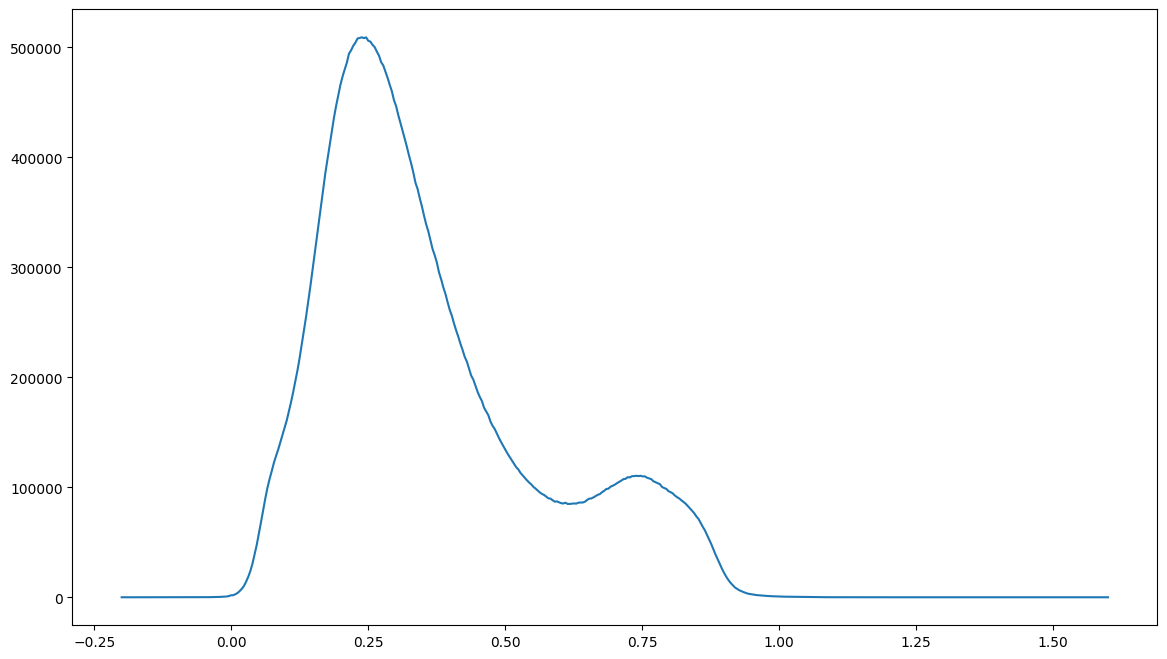

In [57]:
plt.figure(figsize=(14,8))
x = np.linspace(-0.2, 1.6, len_histo)
_hist[51] = _hist[52] #0 values
plt.plot(x, _hist)
#plt.xticks([0,1,2,3,4,5,6,7,8,9,10, 11])
plt.savefig('arvi_unbounded.png')

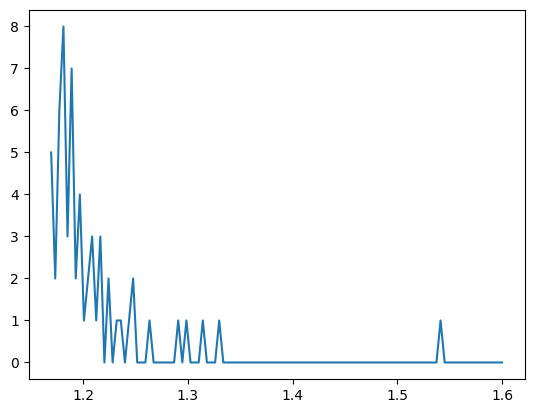

In [58]:
plt.plot(x[350:], _hist[350:])
plt.savefig('arvi_unbounded_noise.png')

#<font color= Blue>Shadow Improvement</font>

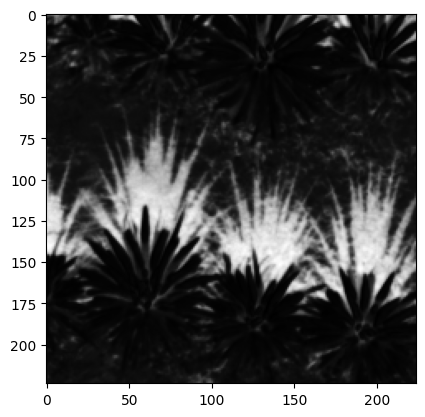

In [59]:
#B, G, R, Re, NIR, t = read_channels(folder, '0853')
#B, G, R, Re, NIR, t = read_channels(folder, '0216')
B, G, R, Re, NIR, t = read_channels(folder, '0356')
U = get_shadow_map(B, G, R, NIR, bin=False) #shadows are the 1's
Uinv = 1-U
plt.imshow(Uinv, cmap='gray')
Im = Image.fromarray(((255*Uinv)/Uinv.max()).astype('uint8')) #convert to pil image
Im.save("Uinv2.png", "PNG") #save image

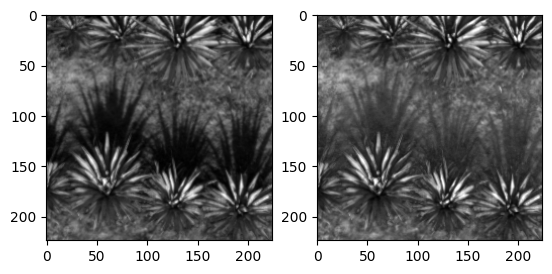

In [60]:
Im = cv2.merge((B, G, R))
HSV = cv2.cvtColor(Im,cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(HSV)
newV = np.clip(V*(1+2*(Uinv)), V.min(), V.max())

plt.subplot(1, 2, 1)
plt.imshow(V, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(newV, cmap='gray')

Im = Image.fromarray(((255*V)/V.max()).astype('uint8')) #convert to pil image
Im.save("V.png", "PNG") #save image
Im = Image.fromarray(((255*newV)/newV.max()).astype('uint8')) #convert to pil image
Im.save("newV.png", "PNG") #save image

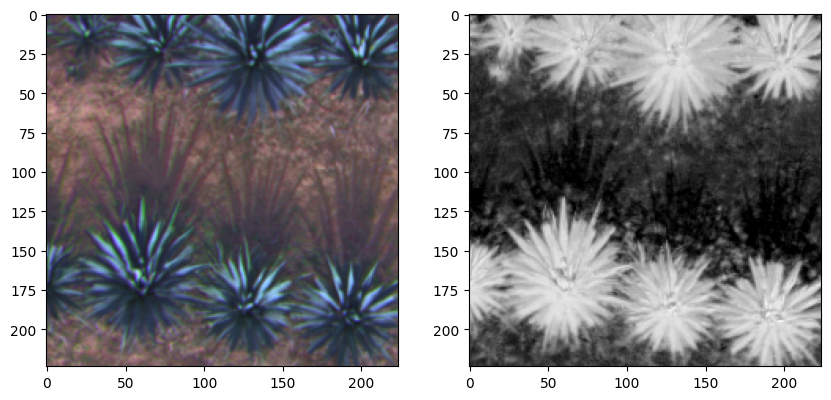

In [61]:
newI = cv2.cvtColor(cv2.merge((H, S, newV)), cv2.COLOR_HSV2RGB)
newR, newG, newB = cv2.split(newI)

scale = 255/(newI.max())
new = (scale*newI).astype('uint8')
ARVI2 = VI((newB, newG, newR, Re, NIR),'ARVI')

rgb = (scale*cv2.merge((newR, newG, newB))).astype('uint8')
ARVI2 = ((255*ARVI2)/ARVI2.max()).astype('uint8')
Im = Image.fromarray(rgb) #convert to pil image
Im.save("RGBcorrected.png", "PNG") #save image
Im = Image.fromarray(ARVI2) #convert to pil image
Im.save("ARVIcorrected.png", "PNG") #save image

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(new)
plt.subplot(1, 2, 2)
plt.imshow(ARVI2, cmap='gray')

#<font color= Blue>Segmentation</font>

In [38]:
#Find a proper range of values of the VI
min_histo = -0.5 #the smallest found value of the VI in dataset
max_histo = 1.6 #the largest found value of the VI in dataset
len_histo = int(np.ceil(256*(max_histo-min_histo))) #define the number of bits of the histogram to setup a step of 1/256
VI_NAME = 'ARVI'

(mini, maxi), _hist1, (miniRecommended, maxiRecommended) = get_total_hist_VI(VI_NAME, len_histo, min_histo, max_histo, shadow_process=False, pData=0.999, bounded=False, dischard_max_value_histogram=True)
(mini, maxi), _hist2, (miniRecommended, maxiRecommended) = get_total_hist_VI(VI_NAME, len_histo, min_histo, max_histo, shadow_process=True, pData=0.999, bounded=False, dischard_max_value_histogram=True)

Min: -0.1951, Max: 1.54044
Min limit recommended 0.027933 in index 135
Max limit recommended 0.935196 in index 367
Min: -0.4814, Max: 2.67932
Min limit recommended -0.206704 in index 75
Max limit recommended 0.923464 in index 364


In [50]:
#Get the histogram with and without shadow improvement
min_histo = 0 #the smallest found value of the VI in dataset
max_histo = 1 #the largest found value of the VI in dataset
len_histo = int(np.ceil(256*(max_histo-min_histo))) #define the number of bits of the histogram to setup a step of 1/256
VI_NAME = 'ARVI'

(mini, maxi), _hist1, (miniRecommended, maxiRecommended) = get_total_hist_VI(VI_NAME, len_histo, min_histo, max_histo, shadow_process=False, bounded=True, ranges=(0, 0.94))
(mini, maxi), _hist2, (miniRecommended, maxiRecommended) = get_total_hist_VI(VI_NAME, len_histo, min_histo, max_histo, shadow_process=True, bounded=True, ranges=(-0.21, 0.93))

Min: 0.0000, Max: 0.99894
Min limit recommended 0.000000 in index 0
Max limit recommended 0.992157 in index 253
Min: 0.0000, Max: 0.99912
Min limit recommended 0.000000 in index 0
Max limit recommended 0.996078 in index 254


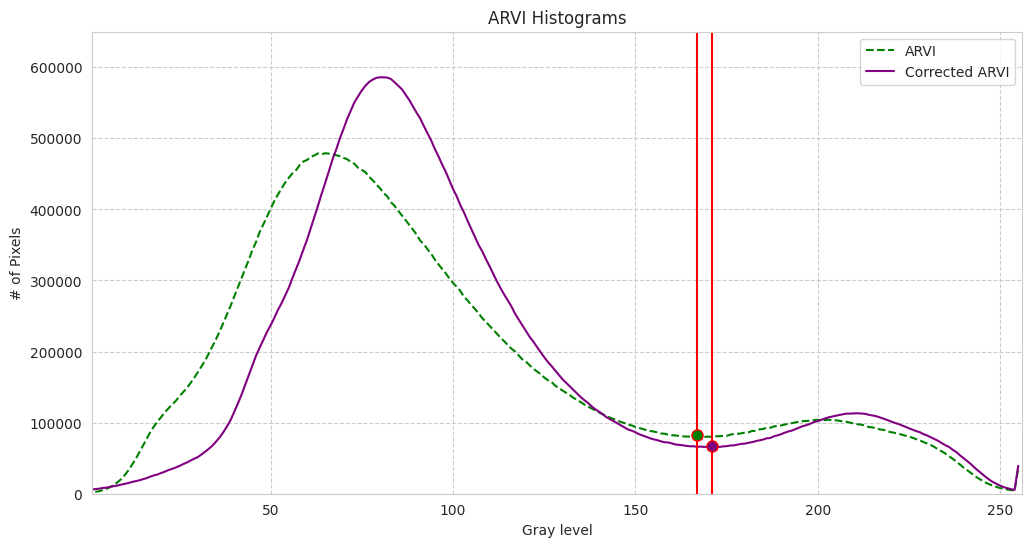

In [51]:
x = np.linspace(0, 255, 256)
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_prop_cycle(color=['green', 'purple'])

#plt.subplot(1, 2, 1)
#plt.plot(_hist[1:])
plt.plot(x, _hist1, linestyle='dashed')
plt.plot(x, _hist2, linestyle='solid')
plt.xlim([1, 256])
plt.ylim([0, 0.65*10**6])
plt.xlabel('Gray level')
plt.ylabel("# of Pixels")
plt.title('ARVI Histograms')
#plt.subplot(1, 2, 2)
#plt.plot(_hist2[1:])
#plt.ylabel("# of Pixels")
#plt.title('Corrected ARVI Histogram')
#plt.yticks([])
plt.legend(labels=['ARVI', 'Corrected ARVI'])
plt.axvline(x = 167, color = 'r')
plt.axvline(x = 171, color = 'r')
plt.plot(167, 0.82*10**5, marker="o", markersize=8, markeredgecolor="red", markerfacecolor="green")
plt.plot(171, 0.67*10**5, marker="o", markersize=8, markeredgecolor="red", markerfacecolor="purple")
plt.savefig('histogramARVI')

In [52]:
find_valleys(_hist1, 5)

[167]

In [53]:
find_valleys(_hist2, 5)

[171]

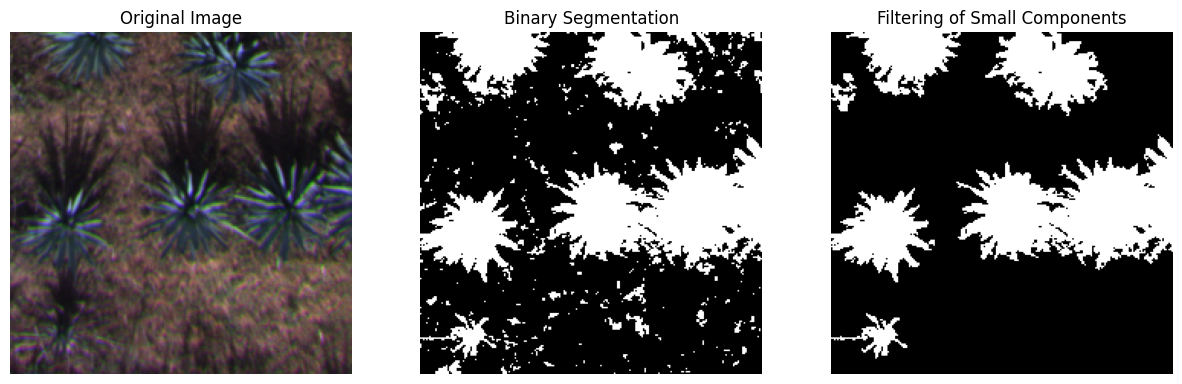

In [88]:
plt.figure(figsize=(15, 5))

imN = '0755'
B, G, R, Re, NIR, t = read_channels(folder, imN)
shadow_map = get_shadow_map(B, G, R, NIR, bin=False) #shadows are the 1's
Im = cv2.merge((B, G, R))
HSV = cv2.cvtColor(Im,cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(HSV)
newI = cv2.cvtColor(cv2.merge((H, S, np.clip(V*(1+2*(1-shadow_map)), V.min(), V.max()) )), cv2.COLOR_HSV2RGB) #131
newR, newG, newB = cv2.split(newI)
ARVI_1 = VI((newB, newG, newR, Re, NIR), 'ARVI', ranges=(-0.21, 0.93), bounded=True)

ret,image_result = cv2.threshold((255*ARVI_1).astype('uint8'),141,255,cv2.THRESH_BINARY)
out = filter_min_components(image_result, minSize=100, it_dilate=0, it_erode=0)

scale = 255/max(np.max(B), max(np.max(G), np.max(R)))
new = (scale*cv2.merge((R, G, B))).astype('uint8')
plt.subplot(1, 3, 1)
plt.imshow(new)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_result, cmap='gray')
plt.title('Binary Segmentation')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(out, cmap='gray')
plt.title('Filtering of Small Components')
plt.axis('off')

#plt.savefig('segmentation.png')
Im = Image.fromarray(image_result) #convert to pil image
Im.save("binary_segmentation.png", "PNG") #save image
Im = Image.fromarray(255*out) #convert to pil image
Im.save("binary_segmentation_filtered.png", "PNG") #save image

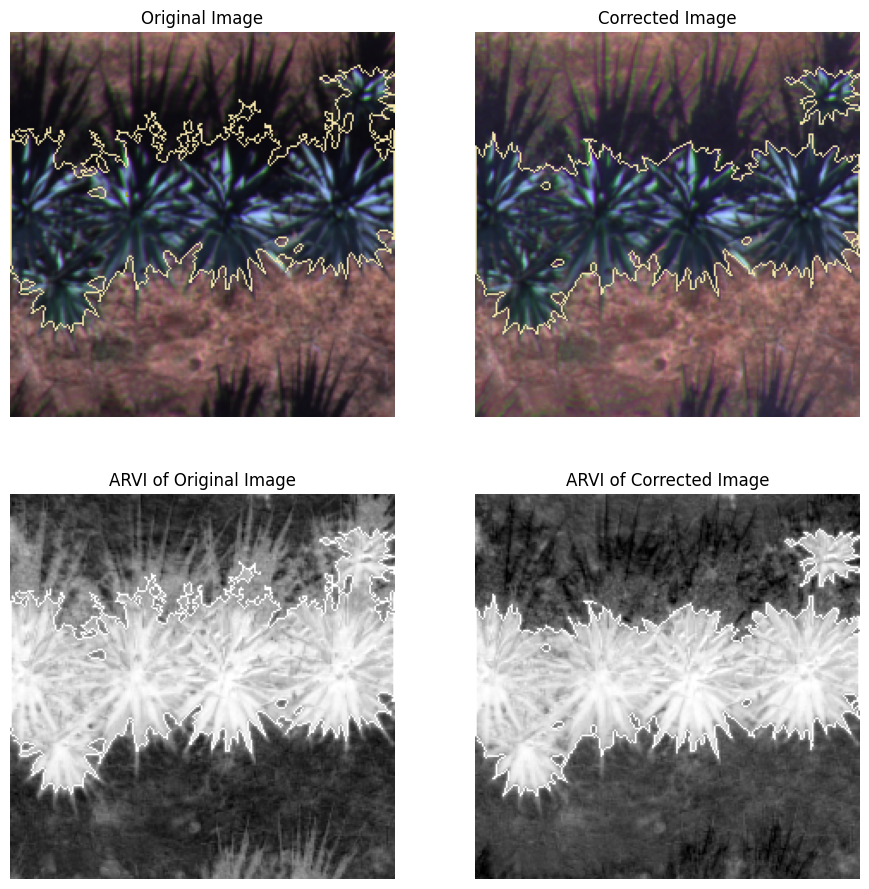

In [90]:
B, G, R, Re, NIR, t = read_channels(folder, '0853')
#B = B[325:475, 150:300]
#G = G[325:475, 150:300]
#R = R[325:475, 150:300]
#NIR = NIR[325:475, 150:300]
##Img 1
scale = 1.05*255/(max(R.max(), max(G.max(), B.max())))
rgb = (scale*cv2.merge((R, G, B))).astype('uint8')
#Img 2
shadow_map = get_shadow_map(B, G, R, NIR, bin=False) #shadows are the 1's
Im = cv2.merge((B, G, R))
HSV = cv2.cvtColor(Im,cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(HSV)
newI = cv2.cvtColor(cv2.merge((H, S, np.clip(V*(1+2*(1-shadow_map)), V.min(), V.max()) )), cv2.COLOR_HSV2RGB)
newR, newG, newB = cv2.split(newI)
scale = 255/(newI.max())
new = (scale*newI).astype('uint8')
#Img 3
ARVI = VI((B, G, R, Re, NIR), 'ARVI', ranges=(0, 0.94))
#Img 4
ARVI2 = VI((newB, newG, newR, Re, NIR), 'ARVI', ranges=(-0.21, 0.93))
#seg1
ret,seg = cv2.threshold((255*ARVI).astype('uint8'),158,255,cv2.THRESH_BINARY)
seg = filter_min_components(seg, minSize=100, it_dilate=0, it_erode=0)
contours, hierarchy = cv2.findContours(seg, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
threshold_area = 10     #threshold area
newContours1=[]
for cnt in contours:
  newContours1.append(cnt) if cv2.contourArea(cnt) > threshold_area else newContours1
cv2.drawContours(ARVI, newContours1, -1, (1, 0, 0), 1)
cv2.drawContours(rgb, newContours1, -1, (243, 229, 171), 1)
#seg2
ret,seg = cv2.threshold((255*ARVI2).astype('uint8'),141,255,cv2.THRESH_BINARY)
seg = filter_min_components(seg, minSize=100, it_dilate=0, it_erode=0)
contours, hierarchy = cv2.findContours(seg, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
threshold_area = 10     #threshold area
newContours2=[]
for cnt in contours:
  newContours2.append(cnt) if cv2.contourArea(cnt) > threshold_area else newContours2
cv2.drawContours(ARVI2, newContours2, -1, (1, 0, 0), 1)
cv2.drawContours(new, newContours2, -1, (243, 229, 171), 1)

plt.figure(figsize=(11, 11))
plt.subplot(2, 2, 1)
#rgb = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(rgb)
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(new)
plt.title('Corrected Image')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(ARVI, cmap='gray')
plt.title('ARVI of Original Image')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(ARVI2, cmap='gray')
plt.title('ARVI of Corrected Image')
plt.axis('off')
#plt.savefig('example.png')

Im = Image.fromarray(rgb) #convert to pil image
Im.save("rgb_border.png", "PNG") #save image
Im = Image.fromarray(new) #convert to pil image
Im.save("rgb_corrected_border.png", "PNG") #save image
Im = Image.fromarray(((255*ARVI)/ARVI.max()).astype('uint8')) #convert to pil image
Im.save("arvi_border.png", "PNG") #save image
Im = Image.fromarray(((255*ARVI2)/ARVI2.max()).astype('uint8')) #convert to pil image
Im.save("arvi_corrected_border.png", "PNG") #save image

In [92]:
#im = ['0028', '0152', '0201', '0218', '0416', '0441','0521', '0872', '0896', '1034']
#im = ['0921', '0624', '0704', '0412', '0216', '0896', '0152']
im = ['0846', '0184', '0216', '0853', '0823', '0518','0257']

plt.figure(figsize=(5*4,len(im)*4))
for i in range(len(im)):
  B, G, R, Re, NIR, target = read_channels(folder, im[i])
  U = get_shadow_map(B, G, R, NIR, bin=False)
  scale=255/max(B.max(), max(R.max(), G.max()))
  rgb = (scale*cv2.merge((R, G, B))).astype('uint8')

  Im = cv2.merge((B, G, R))
  HSV = cv2.cvtColor(Im,cv2.COLOR_BGR2HSV)
  H, S, V = cv2.split(HSV)
  newI = cv2.cvtColor(cv2.merge((H, S, np.clip(V*(1+2*(1-U)), V.min(), V.max()) )), cv2.COLOR_HSV2RGB)
  newR, newG, newB = cv2.split(newI)
  scale = 255/(newI.max())
  new = (scale*newI).astype('uint8')
  plt.subplot(len(im), 5, 5*i+1)
  plt.imshow(new)
  if i==0:
    plt.title('Improved RGB')
  plt.axis('off')

  ARVI2 = VI((newB, newG, newR, Re, NIR), 'ARVI', ranges=(-0.21, 0.93))
  plt.subplot(len(im), 5, 5*i+2)
  plt.imshow(ARVI2, cmap='gray')
  if i==0:
    plt.title('Improved ARVI')
  plt.axis('off')

  tmp_hist = cv2.calcHist([(255*ARVI2).astype('uint8')], [0], None, [256], [0, 256])
  plt.subplot(len(im), 5, 5*i+3)
  plt.plot(tmp_hist[1:])
  if i==0:
    plt.title('ARVI Histogram')
  plt.yticks([])

  valleys = find_valleys(tmp_hist, 3)
  thr = 171
  if len(valleys)>0:
    newT = find_nearest(valleys, value=thr)
    if abs(newT-thr) < 20:
      thr = newT
  ret,seg = cv2.threshold((255*ARVI2).astype('uint8'),thr,255,cv2.THRESH_BINARY)
  plt.subplot(len(im), 5, 5*i+4)
  plt.imshow(seg, cmap='gray')
  if i==0:
    plt.title('Binary Segmentation over Improved ARVI')
  plt.axis('off')

  seg = filter_min_components(seg, minSize=100, it_dilate=0, it_erode=0)
  plt.subplot(len(im), 5, 5*i+5)
  plt.imshow(seg, cmap='gray')
  if i==0:
    plt.title('Filter img')
  plt.axis('off')

plt.savefig('SegmentedExamples.png')

Output hidden; open in https://colab.research.google.com to view.

#<font color= Blue>Scores</font>

In [97]:
file_names = os.listdir(folder)
file_names = [file_name for file_name in file_names if file_name[-3:]=='tif']
classes = ('background', 'agave')
data = []
maximos = 0
for  i, file_name in enumerate(file_names):
  print('\r', "Image: ", i, end='')
  #imN = imNs[i]
  B, G, R, Re, NIR, target = read_channels(folder, file_name[:-4])
  if R.max()>maximos:
    maximos = R.max()
print()
print(maximos)

 Image:  931
0.41588646


In [18]:
#torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes=2
n_channels=3
model = UNet(n_channels, n_classes = num_classes, bilinear=False)

In [19]:
num_epochs=100
optimizer_name='RMSprop'
root = '/content/drive/MyDrive/DCC - Diego Villatoro Gerónimo/Datos Tesis Referencia/Mapas/Unet/' #folder that contain pretrained Unet model
model.load_state_dict(torch.load(root+'Unet-model-'+str(num_epochs)+'-epochs-'+optimizer_name+'.pt' , map_location=torch.device(device) ))

<All keys matched successfully>

In [20]:
def predict(model, file_name):
  # X: [num channels, Height, Weight]
  B, G, R, Re, NIR, target = read_channels(folder, file_name[:-4])
  X = torch.tensor(np.array((B, G, R)))
  model.eval()
  X = X.unsqueeze(0)
  X = X.to(device)
  with torch.no_grad():
      out = model(X)
      # out: batch_size, H, W, num_classes
  #out = out.cpu().numpy()
  preds = out.argmax(axis=-1)
  return np.array(preds[0].cpu())

In [54]:
import time

file_names = os.listdir(folder)
file_names = [file_name for file_name in file_names if file_name[-3:]=='tif']
classes = ('background', 'agave')
data = []
for  i, file_name in enumerate(file_names):
  print('\r', "Image: ", i, end='')
  #imN = imNs[i]
  B, G, R, Re, NIR, target = read_channels(folder, file_name[:-4])
  ###############################################################################################################################
  inicio = time.time()
  ARVI = VI((B, G, R, Re, NIR), 'ARVI', ranges=(0, 0.94))
  ret,seg = cv2.threshold((255*ARVI).astype('uint8'),167,255,cv2.THRESH_BINARY)
  seg1 = filter_min_components(seg, minSize=100, it_dilate=0, it_erode=0)
  fin = time.time()
  time1 = fin-inicio
  ###############################################################################################################################
  inicio = time.time()
  shadow_map = get_shadow_map(B, G, R, NIR, bin=False) #shadows are the 1's
  ret,shadow_map = cv2.threshold(shadow_map,70/255,1,cv2.THRESH_BINARY_INV)
  seg2 = np.logical_and(1-shadow_map, seg1).astype('uint8')
  fin = time.time()
  time2 = fin-inicio + time1  #count the time of compute seg1
  ###############################################################################################################################
  inicio = time.time()
  seg3 = predict(model, file_name)
  fin = time.time()
  time3 = fin-inicio
  ###############################################################################################################################
  inicio = time.time()
  shadow_map = get_shadow_map(B, G, R, NIR, bin=False) #shadows are the 1's
  Im = cv2.merge((B, G, R))
  HSV = cv2.cvtColor(Im,cv2.COLOR_BGR2HSV)
  H, S, V = cv2.split(HSV)
  newI = cv2.cvtColor(cv2.merge((H, S, np.clip(V*(1+2*(1-shadow_map)), V.min(), V.max()) )), cv2.COLOR_HSV2RGB) #131
  newR, newG, newB = cv2.split(newI)
  ARVI_ = VI((newB, newG, newR, Re, NIR), 'ARVI', ranges=(-0.21, 0.93))
  ret,seg = cv2.threshold((255*ARVI_).astype('uint8'),171,255,cv2.THRESH_BINARY)
  seg4 = filter_min_components(seg, minSize=100, it_dilate=0, it_erode=0)
  fin = time.time()
  time4 = fin-inicio
  ###############################################################################################################################

  y = target.reshape(-1)
  y_pred1 = seg1.reshape(-1)
  confusion_mat = confusion_matrix(y, y_pred1, labels=list(range(len(classes))))
  _metrics = metrics(confusion_mat)
  Acc1, specificity1, recall1, precision1, iou1, dice1, tn1, fp1, fn1, tp1 = _metrics

  y_pred2 = seg2.reshape(-1)
  confusion_mat = confusion_matrix(y, y_pred2, labels=list(range(len(classes))))
  _metrics = metrics(confusion_mat)
  Acc2, specificity2, recall2, precision2, iou2, dice2, tn2, fp2, fn2, tp2 = _metrics

  y_pred3 = seg3.reshape(-1)
  confusion_mat = confusion_matrix(y, y_pred3, labels=list(range(len(classes))))
  _metrics = metrics(confusion_mat)
  Acc3, specificity3, recall3, precision3, iou3, dice3, tn3, fp3, fn3, tp3 = _metrics

  y_pred4 = seg4.reshape(-1)
  confusion_mat = confusion_matrix(y, y_pred4, labels=list(range(len(classes))))
  _metrics = metrics(confusion_mat)
  Acc4, specificity4, recall4, precision4, iou4, dice4, tn4, fp4, fn4, tp4 = _metrics

  data.append([file_name, 'ARVI', Acc1, specificity1, recall1, precision1, iou1, dice1, tn1, fp1, fn1, tp1, time1,
             'Shadow Remotion', Acc2, specificity2, recall2, precision2, iou2, dice2, tn2, fp2, fn2, tp2, time2,
             'Unet', Acc3, specificity3, recall3, precision3, iou3, dice3, tn3, fp3, fn3, tp3, time3,
             'Improved ARVI', Acc4, specificity4, recall4, precision4, iou4, dice4, tn4, fp4, fn4, tp4, time4])
df = pd.DataFrame(data, columns=['File Name','Method', 'Acc ARVI', 'Spec ARVI', 'Rec ARVI', 'Prec ARVI', 'IoU ARVI', 'Dice ARVI', 'TN ARVI', 'FP ARVI', 'FN ARVI', 'TP ARVI', 'Time ARVI',
                                 'Method', 'Acc Shadow Rem', 'Spec Shadow Rem', 'Rec Shadow Rem', 'Prec Shadow Rem', 'IoU Shadow Rem', 'Dice Shadow Rem', 'TN Shadow Rem', 'FP Shadow Rem', 'FN Shadow Rem', 'TP Shadow Rem', 'Time Shadow Rem',
                                 'Method', 'Acc Unet', 'Spec Unet', 'Rec Unet', 'Prec Unet', 'IoU Unet', 'Dice Unet', 'TN Unet', 'FP Unet', 'FN Unet', 'TP Unet', 'Time Unet',
                                 'Method', 'Acc Imp ARVI', 'Spec Imp ARVI', 'Rec Imp ARVI', 'Prec Imp ARVI', 'IoU Imp ARVI', 'Dice Imp ARVI', 'TN Imp ARVI', 'FP Imp ARVI', 'FN Imp ARVI', 'TP Imp ARVI', 'Time Imp ARVI',])
df

 Image:  931

File Name Method    Acc ARVI   Spec ARVI    Rec ARVI   Prec ARVI  \
0    0005.tif   ARVI   96.474410   98.403217   86.534216   91.316164   
1    0006.tif   ARVI   99.730947   99.945842   66.459627   88.796680   
2    0004.tif   ARVI   94.465482   96.761370   88.651084   91.531584   
3    0007.tif   ARVI   99.599410   99.991850   82.074613   99.558499   
4    0001.tif   ARVI  100.000000  100.000000  100.000000  100.000000   
..        ...    ...         ...         ...         ...         ...   
927  0928.tif   ARVI   95.685188   98.789056   72.450533   88.879668   
928  0929.tif   ARVI   97.122130   99.217778   78.902628   92.064923   
929  0930.tif   ARVI   98.443479   99.705562   80.556396   95.074946   
930  0931.tif   ARVI   98.353795   99.921987   71.288210   98.146293   
931  0932.tif   ARVI   99.276547   99.985805   58.748552   98.638132   

       IoU ARVI   Dice ARVI  TN ARVI  FP ARVI  ...  Spec Imp ARVI  \
0     79.954674   88.860903    41351      671  ...      98.631669   
1     61.318052   76.021314    49827       27  ...      99.997994   
2     81.931160   90.068309    34807     1165  ...      98.095741   
3     81.776972   89.975062    49073        4  ...      99.985737   
4    100.000000  100.000000    50176        0  ...     100.000000   
..          ...         ...      ...      ...  ...            ...   
927   66.428904   79.828566    43727      536  ...      99.193457   
928   73.878437   84.977112    44648      352  ...      99.524444   
929   77.329463   87.215584    46731      138  ...      99.547675   
930   70.341113   82.588533    47391       37  ...      99.865059   
931   58.275862   73.638344    49306        7  ...      99.935108   

     Rec Imp ARVI  Prec Imp ARVI IoU Imp ARVI  Dice Imp ARVI  TN Imp ARVI  \
0       89.698308      92.711370    83.789667      91.179954        41447   
1       43.167702      99.285714    43.034056      60.173160        49853   
2       90.939172      94.963976    86.755323      92.908005        35287   
3       84.895359      99.255319    84.358047      91.515449        49070   
4      100.000000     100.000000   100.000000     100.000000        50176   
..            ...            ...          ...            ...          ...   
927     78.048368      92.819791    73.604466      84.795590        43906   
928     82.496136      95.227475    79.220779      88.405797        44786   
929     85.152706      92.998679    80.022734      88.902920        46657   
930     77.656477      97.088262    75.889047      86.291953        47364   
931     78.447277      95.486601    75.642458      86.132316        49281   

     FP Imp ARVI  FN Imp ARVI  TP Imp ARVI  Time Imp ARVI  
0            575          840         7314       0.007484  
1              1          183          139       0.005457  
2            685         1287        12917       0.005813  
3              7          166          933       0.007529  
4              0            0            0       0.006592  
..           ...          ...          ...            ...  
927          357         1298         4615       0.002705  
928          214          906         4270       0.002944  
929          212          491         2816       0.002770  
930           64          614         2134       0.002773  
931           32          186          677       0.003220  

[932 rows x 49 columns]

In [58]:
df.to_csv('/content/drive/MyDrive/DCC - Diego Villatoro Gerónimo/Datos Tesis Referencia/Mapas/Unet/metrics_segmentation_compare.csv', index=False)

In [68]:
df=pd.read_csv('/content/drive/MyDrive/DCC - Diego Villatoro Gerónimo/Datos Tesis Referencia/Mapas/Unet/metrics_segmentation_compare.csv')
df

File Name Method    Acc ARVI   Spec ARVI    Rec ARVI   Prec ARVI  \
0    0005.tif   ARVI   96.474410   98.403217   86.534216   91.316164   
1    0006.tif   ARVI   99.730947   99.945842   66.459627   88.796680   
2    0004.tif   ARVI   94.465482   96.761370   88.651084   91.531584   
3    0007.tif   ARVI   99.599410   99.991850   82.074613   99.558499   
4    0001.tif   ARVI  100.000000  100.000000  100.000000  100.000000   
..        ...    ...         ...         ...         ...         ...   
927  0928.tif   ARVI   95.685188   98.789056   72.450533   88.879668   
928  0929.tif   ARVI   97.122130   99.217778   78.902628   92.064923   
929  0930.tif   ARVI   98.443479   99.705562   80.556396   95.074946   
930  0931.tif   ARVI   98.353795   99.921987   71.288210   98.146293   
931  0932.tif   ARVI   99.276547   99.985805   58.748552   98.638132   

       IoU ARVI   Dice ARVI  TN ARVI  FP ARVI  ...  Spec Imp ARVI  \
0     79.954674   88.860903    41351      671  ...      98.631669   
1     61.318052   76.021314    49827       27  ...      99.997994   
2     81.931160   90.068309    34807     1165  ...      98.095741   
3     81.776972   89.975062    49073        4  ...      99.985737   
4    100.000000  100.000000    50176        0  ...     100.000000   
..          ...         ...      ...      ...  ...            ...   
927   66.428904   79.828566    43727      536  ...      99.193457   
928   73.878437   84.977112    44648      352  ...      99.524444   
929   77.329463   87.215584    46731      138  ...      99.547675   
930   70.341113   82.588533    47391       37  ...      99.865059   
931   58.275862   73.638344    49306        7  ...      99.935108   

     Rec Imp ARVI  Prec Imp ARVI IoU Imp ARVI  Dice Imp ARVI  TN Imp ARVI  \
0       89.698308      92.711370    83.789667      91.179954        41447   
1       43.167702      99.285714    43.034056      60.173160        49853   
2       90.939172      94.963976    86.755323      92.908005        35287   
3       84.895359      99.255319    84.358047      91.515449        49070   
4      100.000000     100.000000   100.000000     100.000000        50176   
..            ...            ...          ...            ...          ...   
927     78.048368      92.819791    73.604466      84.795590        43906   
928     82.496136      95.227475    79.220779      88.405797        44786   
929     85.152706      92.998679    80.022734      88.902920        46657   
930     77.656477      97.088262    75.889047      86.291953        47364   
931     78.447277      95.486601    75.642458      86.132316        49281   

     FP Imp ARVI  FN Imp ARVI  TP Imp ARVI  Time Imp ARVI  
0            575          840         7314       0.007484  
1              1          183          139       0.005457  
2            685         1287        12917       0.005813  
3              7          166          933       0.007529  
4              0            0            0       0.006592  
..           ...          ...          ...            ...  
927          357         1298         4615       0.002705  
928          214          906         4270       0.002944  
929          212          491         2816       0.002770  
930           64          614         2134       0.002773  
931           32          186          677       0.003220  

[932 rows x 49 columns]

In [60]:
data = []

TN = np.sum(df['TN ARVI'])
FP = np.sum(df['FP ARVI'])
FN = np.sum(df['FN ARVI'])
TP = np.sum(df['TP ARVI'])
time = np.sum(df['Time ARVI'])/len(df)
data.append([TN, FP, FN, TP, time])

TN = np.sum(df['TN Shadow Rem'])
FP = np.sum(df['FP Shadow Rem'])
FN = np.sum(df['FN Shadow Rem'])
TP = np.sum(df['TP Shadow Rem'])
time = np.sum(df['Time Shadow Rem'])/len(df)
data.append([TN, FP, FN, TP, time])

TN = np.sum(df['TN Unet'])
FP = np.sum(df['FP Unet'])
FN = np.sum(df['FN Unet'])
TP = np.sum(df['TP Unet'])
time = np.sum(df['Time Unet'])/len(df)
data.append([TN, FP, FN, TP, time])

TN = np.sum(df['TN Imp ARVI'])
FP = np.sum(df['FP Imp ARVI'])
FN = np.sum(df['FN Imp ARVI'])
TP = np.sum(df['TP Imp ARVI'])
time = np.sum(df['Time Imp ARVI'])/len(df)
data.append([TN, FP, FN, TP, time])

#Acc', 'Specificity', 'Recall', 'Precision', 'IoU_Agave', 'DICE',
df2 = pd.DataFrame(data, columns=['TN', 'FP', 'FN', 'TP', 'Time'], index = ['ARVI', 'Shadow Remotion', 'Unet', 'Shadow Improve HSV'])
df2['Acc'] = (df2['TP']+df2['TN'])/(df2['TP']+df2['TN']+df2['FP']+df2['FN'])
df2['Specificity'] = (df2['TN'])/(df2['TN']+df2['FP'])
df2['Recall'] = (df2['TP'])/(df2['TP']+df2['FN'])
df2['Precision'] = (df2['TP'])/(df2['TP']+df2['FP'])
df2['IoU'] = (df2['TP'])/(df2['TP']+df2['FN']+df2['FP'])
df2['Dice'] = (2*df2['TP'])/(2*df2['TP']+df2['FN']+df2['FP'])
df2

TN       FP       FN       TP      Time       Acc  \
ARVI                39198941   453111  1306872  5805108  0.001464  0.962365   
Shadow Remotion     39252158   399894  1317181  5794799  0.002714  0.963282   
Unet                37994228  1657824   169138  6942842  0.054792  0.960932   
Shadow Improve HSV  39392831   259221  1171451  5940529  0.003686  0.969407   

                    Specificity    Recall  Precision       IoU      Dice  
ARVI                   0.988573  0.816244   0.927597  0.767355  0.868365  
Shadow Remotion        0.989915  0.814794   0.935446  0.771419  0.870961  
Unet                   0.958191  0.976218   0.807245  0.791676  0.883727  
Shadow Improve HSV     0.993463  0.835285   0.958188  0.805911  0.892525

In [61]:
data = []
for i in range(len(df)):
  data.append(['Accuracy', 'ARVI', df['Acc ARVI'].iloc[i]])
  data.append(['Specificity', 'ARVI', df['Spec ARVI'].iloc[i]])
  data.append(['Recall', 'ARVI', df['Rec ARVI'].iloc[i]])
  data.append(['Precision', 'ARVI', df['Prec ARVI'].iloc[i]])
  data.append(['IoU', 'ARVI', df['IoU ARVI'].iloc[i]])
  data.append(['Dice', 'ARVI', df['Dice ARVI'].iloc[i]])

  data.append(['Accuracy', 'Shadow Remotion on ARVI', df['Acc Shadow Rem'].iloc[i]])
  data.append(['Specificity', 'Shadow Remotion on ARVI', df['Spec Shadow Rem'].iloc[i]])
  data.append(['Recall', 'Shadow Remotion on ARVI', df['Rec Shadow Rem'].iloc[i]])
  data.append(['Precision', 'Shadow Remotion on ARVI', df['Prec Shadow Rem'].iloc[i]])
  data.append(['IoU', 'Shadow Remotion on ARVI', df['IoU Shadow Rem'].iloc[i]])
  data.append(['Dice', 'Shadow Remotion on ARVI', df['Dice Shadow Rem'].iloc[i]])

  data.append(['Accuracy', 'Unet', df['Acc Unet'].iloc[i]])
  data.append(['Specificity', 'Unet', df['Spec Unet'].iloc[i]])
  data.append(['Recall', 'Unet', df['Rec Unet'].iloc[i]])
  data.append(['Precision', 'Unet', df['Prec Unet'].iloc[i]])
  data.append(['IoU', 'Unet', df['IoU Unet'].iloc[i]])
  data.append(['Dice', 'Unet', df['Dice Unet'].iloc[i]])

  data.append(['Accuracy', 'Improved ARVI', df['Acc Imp ARVI'].iloc[i]])
  data.append(['Specificity', 'Improved ARVI', df['Spec Imp ARVI'].iloc[i]])
  data.append(['Recall', 'Improved ARVI', df['Rec Imp ARVI'].iloc[i]])
  data.append(['Precision', 'Improved ARVI', df['Prec Imp ARVI'].iloc[i]])
  data.append(['IoU', 'Improved ARVI', df['IoU Imp ARVI'].iloc[i]])
  data.append(['Dice', 'Improved ARVI', df['Dice Imp ARVI'].iloc[i]])
df2 = pd.DataFrame(data, columns=['Metric','Method', 'Score'])
df2

Metric         Method      Score
0         Accuracy           ARVI  96.474410
1      Specificity           ARVI  98.403217
2           Recall           ARVI  86.534216
3        Precision           ARVI  91.316164
4              IoU           ARVI  79.954674
...            ...            ...        ...
22363  Specificity  Improved ARVI  99.935108
22364       Recall  Improved ARVI  78.447277
22365    Precision  Improved ARVI  95.486601
22366          IoU  Improved ARVI  75.642458
22367         Dice  Improved ARVI  86.132316

[22368 rows x 3 columns]

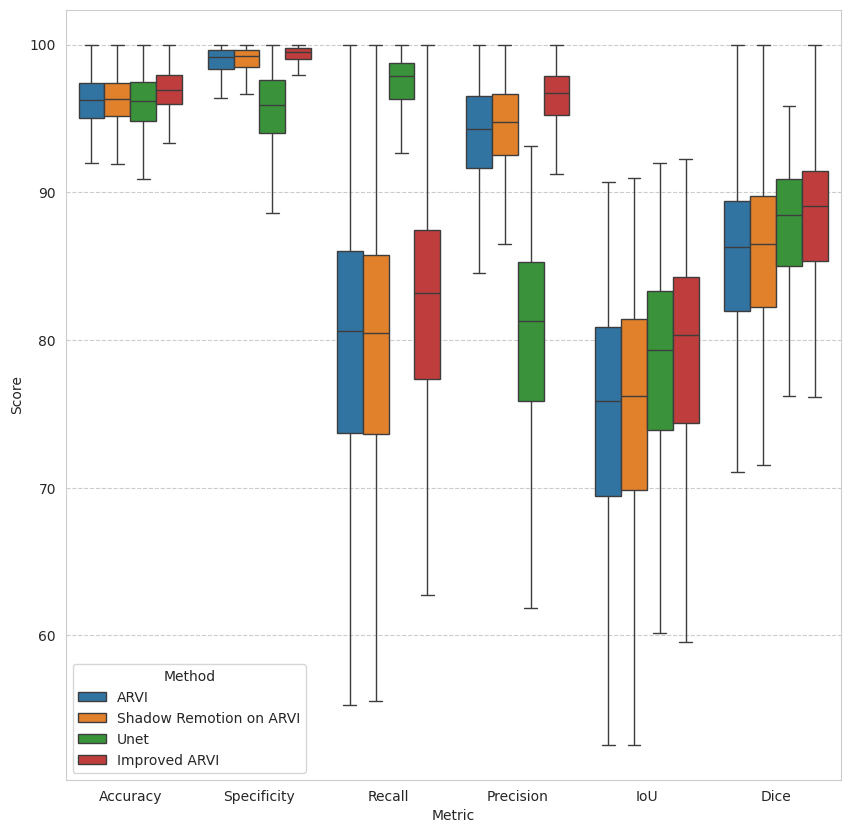

In [62]:
plt.figure(figsize=(10,10))
#df2 = df2.loc[np.logical_and(df2["Score"] != 0.0, df2["Score"] != 100.0 )]
ax = sb.boxplot(x="Metric", y="Score", hue="Method", data=df2, showfliers=False)  # RUN PLOT
sb.set_style("whitegrid", {'grid.linestyle': '--'})
plt.savefig('boxplot_results.png')

In [69]:
df2 = df[['Acc ARVI', 'Acc Shadow Rem', 'Acc Unet', 'Acc Imp ARVI',
          'Spec ARVI', 'Spec Shadow Rem', 'Spec Unet', 'Spec Imp ARVI',
          'Rec ARVI', 'Rec Shadow Rem', 'Rec Unet', 'Rec Imp ARVI',
          'Prec ARVI', 'Prec Shadow Rem', 'Prec Unet', 'Prec Imp ARVI',
          'IoU ARVI', 'IoU Shadow Rem', 'IoU Unet', 'IoU Imp ARVI',
          'Dice ARVI', 'Dice Shadow Rem', 'Dice Unet', 'Dice Imp ARVI']]
#df2['Prom'] = (df2['IoU ARVI']+df2['IoU Shadow Rem']+df2['IoU Unet']+df2['IoU Imp ARVI'])/4
df2 = df2.sort_values('IoU ARVI')
df2

Acc ARVI  Acc Shadow Rem    Acc Unet  Acc Imp ARVI  Spec ARVI  \
12    99.944196       99.944196   99.966119     99.944196      100.0   
16    99.960140       99.960140   99.980070     99.960140      100.0   
786   99.998007       99.998007   99.996014     99.998007      100.0   
55    99.990035       99.990035   99.677136     99.990035      100.0   
731   99.653221       99.653221   99.788744     99.653221      100.0   
..          ...             ...         ...           ...        ...   
451  100.000000      100.000000  100.000000    100.000000      100.0   
809  100.000000      100.000000  100.000000    100.000000      100.0   
760  100.000000      100.000000  100.000000    100.000000      100.0   
887  100.000000      100.000000  100.000000    100.000000      100.0   
902  100.000000      100.000000  100.000000    100.000000      100.0   

     Spec Shadow Rem   Spec Unet  Spec Imp ARVI  Rec ARVI  Rec Shadow Rem  \
12             100.0   99.968094          100.0       0.0             0.0   
16             100.0   99.988037          100.0       0.0             0.0   
786            100.0   99.998007          100.0       0.0             0.0   
55             100.0   99.687070          100.0       0.0             0.0   
731            100.0   99.790008          100.0       0.0             0.0   
..               ...         ...            ...       ...             ...   
451            100.0  100.000000          100.0     100.0           100.0   
809            100.0  100.000000          100.0     100.0           100.0   
760            100.0  100.000000          100.0     100.0           100.0   
887            100.0  100.000000          100.0     100.0           100.0   
902            100.0  100.000000          100.0     100.0           100.0   

     ...   Prec Unet  Prec Imp ARVI  IoU ARVI  IoU Shadow Rem    IoU Unet  \
12   ...   62.790698          100.0       0.0             0.0   61.363636   
16   ...   72.727273          100.0       0.0             0.0   61.538462   
786  ...    0.000000          100.0       0.0             0.0    0.000000   
55   ...    0.000000          100.0       0.0             0.0    0.000000   
731  ...   62.230216          100.0       0.0             0.0   62.007168   
..   ...         ...            ...       ...             ...         ...   
451  ...  100.000000          100.0     100.0           100.0  100.000000   
809  ...  100.000000          100.0     100.0           100.0  100.000000   
760  ...  100.000000          100.0     100.0           100.0  100.000000   
887  ...  100.000000          100.0     100.0           100.0  100.000000   
902  ...  100.000000          100.0     100.0           100.0  100.000000   

     IoU Imp ARVI  Dice ARVI  Dice Shadow Rem   Dice Unet  Dice Imp ARVI  
12            0.0        0.0              0.0   76.056338            0.0  
16            0.0        0.0              0.0   76.190476            0.0  
786           0.0        0.0              0.0    0.000000            0.0  
55            0.0        0.0              0.0    0.000000            0.0  
731           0.0        0.0              0.0   76.548673            0.0  
..            ...        ...              ...         ...            ...  
451         100.0      100.0            100.0  100.000000          100.0  
809         100.0      100.0            100.0  100.000000          100.0  
760         100.0      100.0            100.0  100.000000          100.0  
887         100.0      100.0            100.0  100.000000          100.0  
902         100.0      100.0            100.0  100.000000          100.0  

[932 rows x 24 columns]

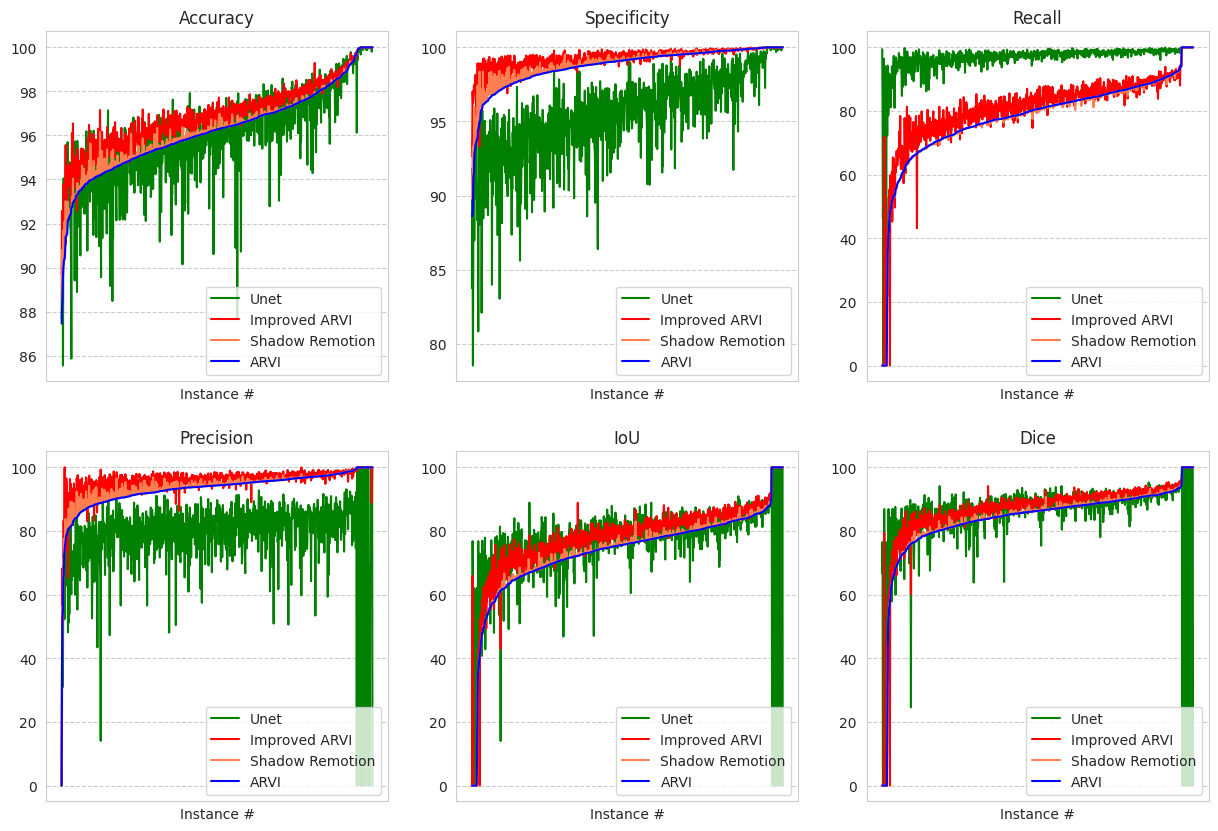

In [70]:
x = range(1, len(df2['IoU ARVI'])+1)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
df2 = df2.sort_values('Acc ARVI')
plt.plot(x, df2['Acc Unet'], "-g", label="Unet")
plt.plot(x, df2['Acc Imp ARVI'], "-r", label="Improved ARVI")
plt.plot(x, df2['Acc Shadow Rem'], "coral", label="Shadow Remotion")
plt.plot(x, df2['Acc ARVI'], "-b", label="ARVI")
plt.legend(loc="lower right")
plt.title('Accuracy')
plt.gca().set_xticks([])
plt.xlabel('Instance #')

plt.subplot(2, 3, 2)
df2 = df2.sort_values('Spec ARVI')
plt.plot(x, df2['Spec Unet'], "-g", label="Unet")
plt.plot(x, df2['Spec Imp ARVI'], "-r", label="Improved ARVI")
plt.plot(x, df2['Spec Shadow Rem'], "coral", label="Shadow Remotion")
plt.plot(x, df2['Spec ARVI'], "-b", label="ARVI")
plt.legend(loc="lower right")
plt.title('Specificity')
plt.gca().set_xticks([])
plt.xlabel('Instance #')

plt.subplot(2, 3, 3)
df2 = df2.sort_values('Rec ARVI')
plt.plot(x, df2['Rec Unet'], "-g", label="Unet")
plt.plot(x, df2['Rec Imp ARVI'], "-r", label="Improved ARVI")
plt.plot(x, df2['Rec Shadow Rem'], "coral", label="Shadow Remotion")
plt.plot(x, df2['Rec ARVI'], "-b", label="ARVI")
plt.legend(loc="lower right")
plt.title('Recall')
plt.gca().set_xticks([])
plt.xlabel('Instance #')

plt.subplot(2, 3, 4)
df2 = df2.sort_values('Prec ARVI')
plt.plot(x, df2['Prec Unet'], "-g", label="Unet")
plt.plot(x, df2['Prec Imp ARVI'], "-r", label="Improved ARVI")
plt.plot(x, df2['Prec Shadow Rem'], "coral", label="Shadow Remotion")
plt.plot(x, df2['Prec ARVI'], "-b", label="ARVI")
plt.legend(loc="lower right")
plt.title('Precision')
plt.gca().set_xticks([])
plt.xlabel('Instance #')

plt.subplot(2, 3, 5)
df2 = df2.sort_values('IoU ARVI')
plt.plot(x, df2['IoU Unet'], "-g", label="Unet")
plt.plot(x, df2['IoU Imp ARVI'], "-r", label="Improved ARVI")
plt.plot(x, df2['IoU Shadow Rem'], "coral", label="Shadow Remotion")
plt.plot(x, df2['IoU ARVI'], "-b", label="ARVI")
plt.legend(loc="lower right")
plt.title('IoU')
plt.gca().set_xticks([])
plt.xlabel('Instance #')

plt.subplot(2, 3, 6)
df2 = df2.sort_values('Dice ARVI')
plt.plot(x, df2['Dice Unet'], "-g", label="Unet")
plt.plot(x, df2['Dice Imp ARVI'], "-r", label="Improved ARVI")
plt.plot(x, df2['Dice Shadow Rem'], "coral", label="Shadow Remotion")
plt.plot(x, df2['Dice ARVI'], "-b", label="ARVI")
plt.legend(loc="lower right")
plt.title('Dice')
plt.gca().set_xticks([])
plt.xlabel('Instance #')
plt.savefig('instanceComparison.png')
plt.show()